# Deep Learning Black-Box and Pattern Recognition Analysis Using Guided Grad-CAM for Phytolith Identification

Iban Berganzo-Besga 1,2,*, Hector A. Orengo 3,4,2, Felipe Lumbreras 5,6, Monica N. Ramsey 1

1. Ramsey Laboratory for Environmental Archaeology (RLEA), University of Toronto Mississauga (UTM), 3359 Mississauga Road, Mississauga, ON, L5L 1C6, Canada

2. Landscape Archaeology Research Group (GIAP), Catalan Institute of Classical Archaeology (ICAC), Plaça Rovellat s/n, 43003, Tarragona, Spain

3. Catalan Institution for Research and Advanced Studies (ICREA), Passeig Lluís Companys 23, 08010, Barcelona, Spain

4. Computational Social Sciences and Humanities Department, Barcelona Supercomputing Center (BSC-CNS), Plaça d'Eusebi Güell, 1-3, Les Corts, 08034, Barcelona, Spain

5. Computer Vision Center (CVC), 08193, Bellaterra (Cerdanyola del Vallès), Spain

6. Department of Computer Science, Universitat Autònoma de Barcelona (UAB), 08193, Bellaterra (Cerdanyola del Vallès), Spain

\* Correspondence author


---

# VGG19 and TensorFlow 2 Guided Grad-CAM Implementation

# 1. Initialization

---

In [1]:
# Set TensorFlow version to 2.15

# !pip install tf-keras==2.15.0 tensorflow==2.15
!pip install tf-keras==2.15.0 tensorflow==2.15 keras==2.15.0 ml-dtypes==0.2.0 tensorboard==2.15.2 tensorflow-estimator==2.15.0 wrapt==1.14.1 --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
      Successfully uninstalled tf_keras-2.17.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successful

In [2]:
# Imports

import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from PIL import Image
from skimage import io
from tensorflow.python.framework import ops
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.15.0


In [4]:
# GitHub Repository

!git clone https://github.com/iberganzo/ArchaeolGradCAM

Cloning into 'ArchaeolGradCAM'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
# Paths

os.mkdir('Tiles')
os.mkdir('GradCAM')
os.mkdir('Guided_Backpropagation')
os.mkdir('Guided_GradCAM')

path=os.path.abspath(os.getcwd())
imagesPath = os.path.join(path,'DatatoAnalyse')
tilesPath = os.path.join(path,'Tiles')
GCPath = os.path.join(path,'GradCAM')
guidedBPPath = os.path.join(path,'Guided_Backpropagation')
guidedGCPath = os.path.join(path,'Guided_GradCAM')

In [4]:
# Download the weights of the trained model

!apt-get update
!apt-get install megatools

!megadl 'https://mega.nz/#!ER8GXIgS!--jyrQr_ImHiGhpqIckF2F4q55e1M2dKss4nU2t9JJE'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Ign:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,308 kB]
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:14 http://archive.ubuntu.com/ubu

In [5]:
# Auxiliary functions #

def generate_prediction (img):

    imageR = img.resize((sx,sy))
    image_array = np.array(imageR)
    image_array = image_array.reshape((sy,sx,ch))
    pred_images = np.zeros(shape=(1,sy,sx,ch))
    pred_images[0] = image_array
    pred_images = pred_images.astype('uint8')

    pred = model.predict(pred_images, batch_size=1)

    pred_index = np.argmax(pred)

    print("Prediction: ", class_names[pred_index])

    return pred_index

In [6]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(sy, sx))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# Gradient-weighted Class Activation Mapping (Grad-CAM) #

def generate_grad_cam(img):
    img = cv2.resize(img, (sx, sy))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    # Gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, target_class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    grads = tf.reduce_mean(grads, axis=(0, 1))

    cam = tf.reduce_sum(tf.multiply(conv_outputs[0], grads), axis=-1)

    # Normalise
    cam = cam.numpy()
    cam = cv2.resize(cam, (sy, sx))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    # Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    # Combine guided_bp with the original image
    img_gc = cv2.imread(image_path)
    img_gc = cv2.resize(img_gc, (sx, sy))
    img_gc = img_gc.astype(np.float32) / 255.0
    img_gc = np.expand_dims(img_gc, axis=0)
    img_gc = img_gc[0]
    img_gc = np.float32(cv2.cvtColor(img_gc, cv2.COLOR_RGB2BGR))
    overlay_gc = heatmap + img_gc
    overlay_gc = overlay_gc / np.max(overlay_gc)

    gradcam =  np.uint8(255 * overlay_gc)

    # print("Gradcam shape:", gradcam.shape)

    return cam, heatmap, gradcam

In [8]:
# Guided Backpropagation #

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [9]:
def generate_guided_backpropagation(preprocessed_input):
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
      if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

    # Gradients
    with tf.GradientTape() as tape:
      inputs = tf.cast(preprocessed_input, tf.float32)
      tape.watch(inputs)
      outputs = gb_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]

    guided_bp1 = np.flip(deprocess_image(np.array(grads)),-1)

    gradBGR =  grads.numpy()

    guided_bp = np.dstack((
        gradBGR[:, :, 2],  # R
        gradBGR[:, :, 1],  # G
        gradBGR[:, :, 0],  # B
    ))

    # Combine guided_bp with the original image
    img_bp = cv2.imread(image_path)
    img_bp = cv2.resize(img_bp, (sx, sy))
    img_bp = img_bp.astype(np.float32) / 255.0
    img_bp = np.expand_dims(img_bp, axis=0)
    img_bp = img_bp[0]
    img_bp = np.float32(cv2.cvtColor(img_bp, cv2.COLOR_RGB2BGR))
    overlay_bp = img_bp + guided_bp1
    overlay_bp = overlay_bp / np.max(overlay_bp)

    guided_backprop =  np.uint8(255 * overlay_bp)

    # print("Guided_bp shape:", guided_bp.shape)

    return guided_bp, guided_bp1, guided_backprop

In [10]:
# Guided Grad-CAM #

def generate_guided_grad_cam(cam, guided_bp):

  guided_gradcam = np.dstack((
        guided_bp[:, :, 0] * cam,
        guided_bp[:, :, 1] * cam,
        guided_bp[:, :, 2] * cam,
    ))

  guided_gradcam -= np.min(guided_gradcam)
  guided_gradcam /= guided_gradcam.max()

  # print("Guided_gradcam shape:", guided_gradcam.shape)

  return guided_gradcam

In [11]:
# Auxiliary functions #

def visualize_guided_backpropagation(guided_bp):

  guided_bp_v = np.dstack((
        guided_bp[:, :, 0],
        guided_bp[:, :, 1],
        guided_bp[:, :, 2],
    ))

  guided_bp_v -= np.min(guided_bp_v)
  guided_bp_v /= guided_bp_v.max()

  return guided_bp_v

In [12]:
def extract_number_after_split(filename):
    parts = filename.split('_split_')
    if len(parts) > 1:
        return int(''.join(filter(str.isdigit, parts[1])))
    else:
        return float('inf')

In [17]:
def merge_images(target_layer, typeName, imgOriginal, input_folder, imName, width, height, channels):
    # Merge all the cropped images
    merged_image = Image.new('RGBA', (width, height)) # Empty image
    gc_splitted_images = sorted(os.listdir(input_folder), key=extract_number_after_split)

    x, y = 0, 0
    for gc_splitted_image in gc_splitted_images:
        if gc_splitted_image.endswith(('.jpg', '.png')):
            gc_image = Image.open(os.path.join(input_folder, gc_splitted_image))
            merged_image.paste(gc_image, (x, y))
            x += gc_image.width
            if x >= width:
                x = 0
                y += gc_image.height

    merged_image.save('%s_%s_%s.png' %(imName, target_layer, typeName))

    # Have the original image as 0.5 gray background
    aux_img = imgOriginal.convert('L')
    aux_img = aux_img.convert('RGBA')
    if typeName == 'GradCAM':
        blended_image = Image.blend(aux_img, merged_image, alpha=0.5)
    else:
        blended_image = Image.alpha_composite(aux_img, merged_image)
    blended_image.save('%s_%s_%s_back.png' %(imName, target_layer, typeName))

    print("%s created: %s " %(typeName,imName))

    return blended_image

# 2. Processing

---

In [14]:
# VGG19 #

# Define the parameters

tesela = 256 # Image size
channels = 3 # Image channels
target_layer_list = ["block5_pool"] # Network layer

# First it learns from basic elements such as edges and then from combinations of the elements learnt in previous layers
#target_layer_list = [ # VGG19 layers
#    "block1_conv1", "block1_conv2", "block1_pool", "block2_conv1", "block2_conv2",
#    "block2_pool", "block3_conv1", "block3_conv2", "block3_conv3", "block3_conv4",
#    "block3_pool", "block4_conv1", "block4_conv2", "block4_conv3", "block4_conv4",
#    "block4_pool","block5_conv1", "block5_conv2", "block5_conv3", "block5_conv4", "block5_pool"]

numclasses = 5 # Model number of classes
class_names = ['Avena','Hordeum','Triticum', 'Background', 'Artifact'] # Model classes' names

target_class_index = 2 # Model class to analyse using Guided Grad-CAM: 0: Avena, 1: Hordeum, 2: Triticum, 3: Background, 4: Artifact
cam_th = 0.75 # Guided Grad-CAM threshold based on Grad-CAM heatmap

In [15]:
# Define the model

sx, sy, ch = tesela, tesela, channels
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(sx, sy, ch))
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(numclasses, activation="softmax")
])
model.load_weights('RGB_RJBDA_VGG19_PreTrained_Ref_5C_1.h5')

print("MODEL: ")
# Print model layers
for layer in model.layers:
    print('Layer: ', layer.name)

print("\n")
print("VGG19: ")
# Print base model layers
for layer in base_model.layers:
    print('Layer: ', layer.name)

80134624/80134624 [==============================] - 5s 0us/step
MODEL: 
Layer:  vgg19
Layer:  global_average_pooling2d
Layer:  dense


VGG19: 
Layer:  input_1
Layer:  block1_conv1
Layer:  block1_conv2
Layer:  block1_pool
Layer:  block2_conv1
Layer:  block2_conv2
Layer:  block2_pool
Layer:  block3_conv1
Layer:  block3_conv2
Layer:  block3_conv3
Layer:  block3_conv4
Layer:  block3_pool
Layer:  block4_conv1
Layer:  block4_conv2
Layer:  block4_conv3
Layer:  block4_conv4
Layer:  block4_pool
Layer:  block5_conv1
Layer:  block5_conv2
Layer:  block5_conv3
Layer:  block5_conv4
Layer:  block5_pool




Target Layer:  block5_pool


Data to Analyse:  Figure1.jpg
Analysed:  Figure1_split_1.jpg
1/1 [==============================] - 0s 19ms/step
Prediction:  Background
Analysed:  Figure1_split_2.jpg
1/1 [==============================] - 0s 17ms/step
Prediction:  Background
Analysed:  Figure1_split_3.jpg
1/1 [==============================] - 0s 17ms/step
Prediction:  Background
Analysed:  Figure1_split_4.jpg
1/1 [==============================] - 0s 18ms/step
Prediction:  Background
Analysed:  Figure1_split_5.jpg
1/1 [==============================] - 0s 18ms/step
Prediction:  Background
Analysed:  Figure1_split_6.jpg
1/1 [==============================] - 0s 18ms/step
Prediction:  Background
Analysed:  Figure1_split_7.jpg
1/1 [==============================] - 0s 16ms/step
Prediction:  Background
Analysed:  Figure1_split_8.jpg
1/1 [==============================] - 0s 16ms/step
Prediction:  Artifact
Analysed:  Figure1_split_9.jpg
1/1 [==============================] - 0s 25ms/step
Pr

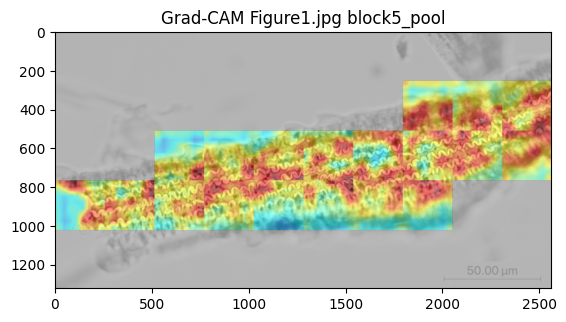

In [18]:
# Main #

for itL in range(0,len(target_layer_list),1):

  target_layer = target_layer_list[itL]
  print("\n")
  print("Target Layer: ", target_layer)

  input_tensor = model.layers[0].input
  inputs_tensor = model.layers[0].inputs
  last_conv_layer = model.layers[0].get_layer(target_layer)
  grad_model = tf.keras.models.Model(inputs=input_tensor, outputs=[last_conv_layer.output, model.layers[0].output]) # Grad-CAM
  gb_model = Model(inputs = [inputs_tensor], outputs = [last_conv_layer.output]) # Guided Backpropagation

  for filenameR in glob.glob("DatatoAnalyse/.*"): # Remove previous files
      if os.path.isdir(filenameR):
            os.rmdir(filenameR)
      else:
            os.remove(filenameR)

  images_list=os.listdir(imagesPath)
  images_list=sorted(images_list)
  for iM in range(0,len(images_list),1):

      print("\n")
      print("Data to Analyse: ", images_list[iM])

      # Splitting the image into tiles
      for filenameR in glob.glob("Tiles/*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("Tiles/.*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("GradCAM/*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("GradCAM/.*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("Guided_Backpropagation/*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("Guided_Backpropagation/.*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("Guided_GradCAM/*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)
      for filenameR in glob.glob("Guided_GradCAM/.*"): # Remove previous files
            if os.path.isdir(filenameR):
                  os.rmdir(filenameR)
            else:
                  os.remove(filenameR)

      imgOriginal = cv2.imread('DatatoAnalyse/%s' %images_list[iM])
      imgOriginal_pil = Image.open('DatatoAnalyse/%s' %images_list[iM])
      height, width, channels = imgOriginal.shape
      [imName,imExt] = os.path.splitext("%s" %images_list[iM])

      num=1
      for i in range(0,height,tesela):
        for j in range(0,width,tesela):
          cropped_image = imgOriginal[i:i+tesela, j:j+tesela]
          tilesPath1 = os.path.join(tilesPath,'%s_split_%d.jpg' %(imName,num))
          cv2.imwrite(tilesPath1, cropped_image)
          num=num+1

      tiles_list=os.listdir(tilesPath)
      tiles_list = sorted(tiles_list, key=extract_number_after_split)
      for iM2 in range(0,len(tiles_list),1):

          print("Analysed: ", tiles_list[iM2])

          image_path = os.path.join(tilesPath, tiles_list[iM2])
          preprocessed_input = load_image(image_path)
          img_original = cv2.imread(image_path)
          img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
          img_pil = Image.open(image_path)

          pred_index = generate_prediction(img_pil)
          image_tr = Image.new('RGBA', (tesela, tesela), (0, 0, 0, 0)) # Transparent image

          if pred_index == target_class_index:
              cam, heatmap, gradcam = generate_grad_cam(img_original)
              cam1 = cam; cam1[cam1 < cam_th] = 0
              guided_bp, guided_bp1, guided_backprop = generate_guided_backpropagation(preprocessed_input)
              guided_bp_v = visualize_guided_backpropagation(guided_bp)
              guided_gc = generate_guided_grad_cam(cam1, guided_bp)

              output_path = os.path.join(GCPath, '%s_split_%d.jpg' %(imName,iM2))
              plt.imsave(output_path, heatmap)
              output_path = os.path.join(guidedBPPath, '%s_split_%d.jpg' %(imName,iM2))
              plt.imsave(output_path, guided_bp_v)
              output_path = os.path.join(guidedGCPath, '%s_split_%d.jpg' %(imName,iM2))
              plt.imsave(output_path, guided_gc)
          else:
              output_path = os.path.join(GCPath, '%s_split_%d.png' %(imName,iM2))
              image_tr.save(output_path)
              output_path = os.path.join(guidedBPPath, '%s_split_%d.png' %(imName,iM2))
              image_tr.save(output_path)
              output_path = os.path.join(guidedGCPath, '%s_split_%d.png' %(imName,iM2))
              image_tr.save(output_path)

      # Merge the Guided Grad-CAM divided images

      merged_image_gc = merge_images(target_layer, 'GradCAM', imgOriginal_pil, GCPath, imName, width, height, channels)
      merged_image_gbp = merge_images(target_layer, 'GuidedBackProp', imgOriginal_pil, guidedBPPath, imName, width, height, channels)
      merged_image_ggc = merge_images(target_layer, 'GuidedGradCAM', imgOriginal_pil, guidedGCPath, imName, width, height, channels)

      plt.figure()
      plt.imshow(merged_image_gc)
      plt.title('Grad-CAM %s %s' %(images_list[iM], target_layer))

# 3. References

---

1. Berganzo-Besga, I. 2022. ArchaeolPhytoliths: Automated detection and classification of multi-cell phytoliths at genera and species-level using Deep Learning algorithm. GitHub repository. Available online: https://github.com/iberganzo/ArchaeolPhytoliths (Accessed 23 August 2024)
2. Gildenblat J. 2017. Grad-CAM implementation in Keras. Available online: https://github.com/jacobgil/keras-grad-cam (Accessed 23 August 2024)
3. Petsiuk V. 2017. keras-gradcam. Available online: https://github.com/eclique/keras-gradcam (Accessed 23 August 2024)
4. Nguyen H. 2020. Demo GradCAM & Guided GradCAM. Available online: https://github.com/hnguyentt/GradCAM_and_GuidedGradCAM_tf2 (Accessed 23 August 2024)
